<a href="https://colab.research.google.com/github/M-H-Amini/Computer-Vision-in-Practice-Course/blob/main/CVinPractice_Lecture3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  In The Name Of ALLAH
#  Computer Vision in Practice
#  Mohammad Hossein Amini (mhamini@aut.ac.ir)
#  PythonChallenge.ir
#  Lecture 3 - Semantic Segmentation

In [ ]:
import os
import numpy as np
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.callbacks import History
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from PIL import Image

#  Data Preparation

In [ ]:
!gdown --id 1vWJ1TrZvzeU9UGAwMRj8qfYUNiQvtUKn

Downloading...
From: https://drive.google.com/uc?id=1vWJ1TrZvzeU9UGAwMRj8qfYUNiQvtUKn
To: /content/Hair.zip
100% 369M/369M [00:08<00:00, 45.1MB/s]


In [ ]:
!unzip -q Hair.zip -d .

In [ ]:
images = 'Images'
targets = 'Masks'

image_files = os.listdir(images)
label_files = os.listdir(targets)
print(len(label_files), label_files[:10])

final_images = []
final_labels = []

for file in tqdm(image_files):
  if len(os.path.basename(file)) < 9:
    image_name = f'{int(file.split(".")[0]):05}'
    src = os.path.join(images, file)
    dst = os.path.join(images, image_name+'.jpg')
    os.rename(src, dst)

for file in tqdm(image_files):
  image_name = os.path.basename(file).split('.')[0]
  target_name = image_name + '_hair.png'
  if target_name in label_files:
    final_images.append(os.path.join(images, image_name+'.jpg'))
    final_labels.append(os.path.join(targets, target_name))

images_array = []
labels_array = []

size = (256, 256)

N = 250

for image_file, label_file in tqdm(zip(final_images[:N], final_labels[:N])):
  images_array.append(np.array(Image.open(image_file).resize(size)))
  labels_array.append(np.array(Image.open(label_file).resize(size)))
  
images = np.array(images_array)
labels = np.array(labels_array)[:, :, :, 0]

print(images.shape, labels.shape)


index = 15

labels = np.expand_dims(labels, 3)

images = images / 255.
mean = np.mean(images)
std = np.std(images)
images = (images - mean) / std
labels = labels / 255.

print('Data is ready!')
print(images.shape, labels.shape)

2972 ['02281_hair.png', '01409_hair.png', '00785_hair.png', '00247_hair.png', '01814_hair.png', '02959_hair.png', '02966_hair.png', '00007_hair.png', '00709_hair.png', '01501_hair.png']


100%|██████████| 3001/3001 [00:00<00:00, 26165.63it/s]
250it [00:08, 29.92it/s]


(250, 256, 256, 3) (250, 256, 256)
Data is ready!
(250, 256, 256, 3) (250, 256, 256, 1)


In [ ]:
N = 220  #  No of samples used for training
images_train, images_test = images[:N], images[N:]
labels_train, labels_test = labels[:N], labels[N:]

print(images_train.shape, images_test.shape)
print(labels_train.shape, labels_test.shape)

(220, 256, 256, 3) (30, 256, 256, 3)
(220, 256, 256, 1) (30, 256, 256, 1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


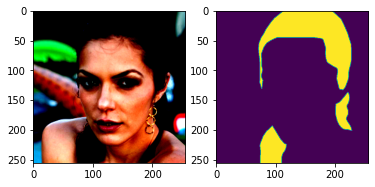

In [ ]:
index = 210
def show(image, label):
  plt.figure()
  plt.subplot(1, 2, 1)
  plt.imshow(image)
  plt.subplot(1, 2, 2)
  plt.imshow(label)
  plt.show()

show(images_train[index], labels_train[index, :, :, 0])

#  Model

In [ ]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

opt = Adam(1e-4)

In [ ]:
def get_unet(img_rows, img_cols):
    inputs = Input((img_rows, img_cols, 3))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=opt, loss=dice_coef_loss, metrics=[dice_coef])

    return model


In [ ]:
model = get_unet(256, 256)
model_checkpoint = ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True)

In [ ]:
opt.learning_rate = 0.0001

In [ ]:
history = model.fit(images_train, labels_train, batch_size=32, epochs=5, shuffle=True,
          validation_data=(images_test, labels_test), callbacks=[model_checkpoint])

Epoch 1/5
7/7 [==============================] - 75s 5s/step - loss: -0.4220 - dice_coef: 0.4217 - val_loss: -0.4046 - val_dice_coef: 0.4046
Epoch 2/5
7/7 [==============================] - 8s 1s/step - loss: -0.4419 - dice_coef: 0.4425 - val_loss: -0.4252 - val_dice_coef: 0.4252
Epoch 3/5
7/7 [==============================] - 8s 1s/step - loss: -0.4748 - dice_coef: 0.4759 - val_loss: -0.4722 - val_dice_coef: 0.4722
Epoch 4/5
7/7 [==============================] - 8s 1s/step - loss: -0.5313 - dice_coef: 0.5307 - val_loss: -0.5093 - val_dice_coef: 0.5093
Epoch 5/5
7/7 [==============================] - 8s 1s/step - loss: -0.5605 - dice_coef: 0.5614 - val_loss: -0.5315 - val_dice_coef: 0.5315


In [ ]:
model.load_weights('weights.h5')

In [ ]:
out = model(images_test).numpy()

In [ ]:
model.save('MHHair')